# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

In [113]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
# TODO: Make all necessary imports.
import json
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
# alias for ease of type-hinting:
from tensorflow.data import Dataset

## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [2]:
# TODO: Load the dataset with TensorFlow Datasets.
BATCH_SIZE: int = 64
IMAGE_SHAPE: int = 224
DATASET: dict[str, Dataset]
INFO: dict[str, any]
DATASET, INFO = tfds.load(
    "oxford_flowers102",
    as_supervised=True,
    with_info=True,
)

# print(f"DATASET Keys: {DATASET.keys()}")  # 'train', 'test', 'validation'

# for image, _ in DATASET["train"].take(1):
#     print(image.shape)  # (500, 667, 3) => RGB images, not of desired size
#     print(image.dtype)  # <dtype: 'uint8'> => 8-bit unsigned => 0-255
# tfds.show_examples(DATASET["train"], INFO)

# TODO: Create a training set, a validation set and a test set.
TRAINING_SET: Dataset = DATASET["train"]
TESTING_SET: Dataset = DATASET["test"]
VALIDATION_SET: Dataset = DATASET["validation"]
# Delegate normalisation and rescaling to pipeline phase

## Explore the Dataset

In [3]:
# TODO: Get the number of examples in each set from the dataset info.
NUMBER_OF_TRAINING_EXAMPLES: int = INFO.splits["train"].num_examples
NUMBER_OF_TESTING_EXAMPLES: int = INFO.splits["test"].num_examples
NUMBER_OF_VALIDATION_EXAMPLES: int = INFO.splits["validation"].num_examples

# TODO: Get the number of classes in the dataset from the dataset info.
NUMBER_OF_CLASSES: int = INFO.features["label"].num_classes


print(
    f"There are {NUMBER_OF_TRAINING_EXAMPLES} training examples, "
    f"{NUMBER_OF_TESTING_EXAMPLES} testing examples, "
    f"{NUMBER_OF_VALIDATION_EXAMPLES} validation examples, and "
    f"{NUMBER_OF_CLASSES} classes in the dataset."
)

There are 1020 training examples, 6149 testing examples, 1020 validation examples, and 102 classes in the dataset.


In [4]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
for index, (image, label) in enumerate(DATASET["train"].take(3)):
    # `label` is a scalar tensor => need to convert to a scalar variable
    print(f"Image {index}: Shape={image.shape}, Label={label.numpy()}")

Image 0: Shape=(500, 667, 3), Label=72
Image 1: Shape=(500, 666, 3), Label=84
Image 2: Shape=(670, 500, 3), Label=70


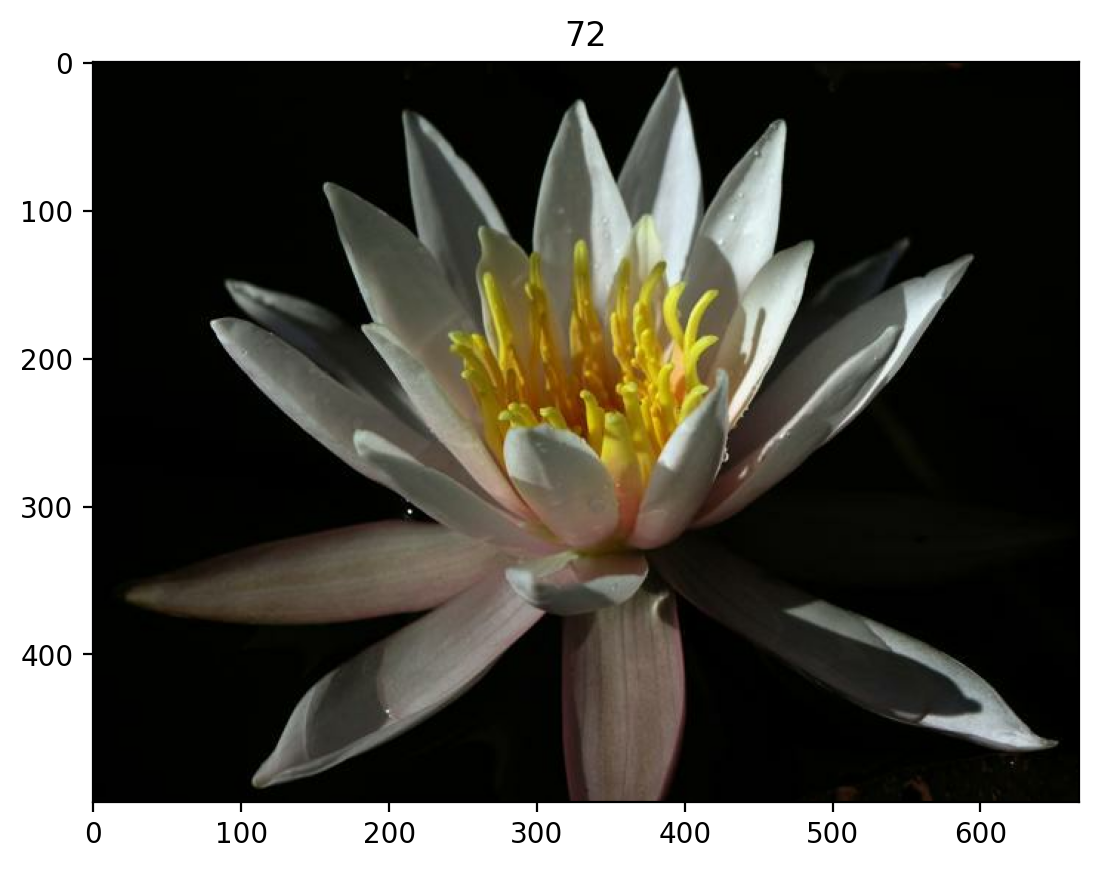

In [5]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding image label. 
for image, label in DATASET["train"].take(1):
    image_array = image.numpy()
    label_number = label.numpy()

plt.imshow(image_array)
plt.title(label_number)
plt.show()

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [6]:
class_names: dict[str, str]  #  format: {"label": "name"}
with open("label_map.json", "r") as f:  # Note: requires the target file to be in the same dir level
    class_names = json.load(f)

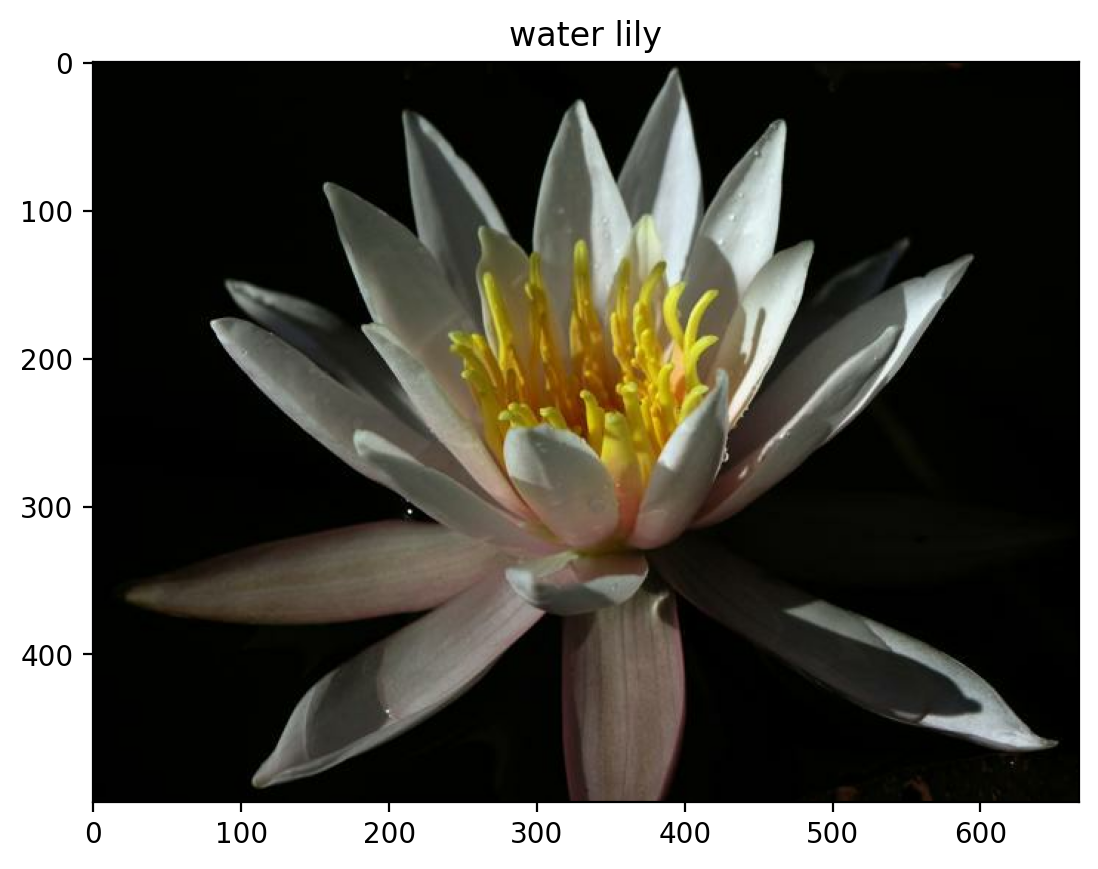

In [89]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 
# Reuse previous image:
plt.imshow(image_array) 
plt.title(class_names[str(label_number + 1)])  # label_map.json starts from index 1, but dataset labels start from index 0
plt.show()

## Create Pipeline

In [8]:
# TODO: Create a pipeline for each set.
def format_image(image: tf.Tensor, label: tf.Tensor) -> tuple[tf.Tensor, tf.Tensor]:
    image_float = tf.cast(image, tf.float32)
    rescaled_image = tf.image.resize(image_float, (IMAGE_SHAPE, IMAGE_SHAPE))
    formatted_image = rescaled_image / 255
    return formatted_image, label

AUTOTUNE = tf.data.AUTOTUNE
TRAINING_BATCHES: Dataset = TRAINING_SET.shuffle(NUMBER_OF_TRAINING_EXAMPLES // 4).map(format_image).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
TESTING_BATCHES: Dataset = TESTING_SET.map(format_image).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
VALIDATION_BATCHES: Dataset = VALIDATION_SET.map(format_image).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [9]:
tf.keras.backend.clear_session()  # Some tuning was done; clearing to save space between attempts.
# TODO: Build and train your network.
# Load MobileNet
MOBILENET_URL:str = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
# Input shape is 224 by 224 by 3, by inspection.
mobile_net_model: tf.keras.layers.Layer = hub.KerasLayer(MOBILENET_URL, input_shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3))
mobile_net_model.trainable = False  # Don't change weights of CNN

In [10]:
# Build a new feed-forward network - tacked on more layers just to see what would happen
# 3 layers from 512 -> 128 yields: loss: 0.2194 - accuracy: 0.9402 - val_loss: 0.9146 - val_accuracy: 0.7608
# attempt adding a new 1024-neuron layer to improve results
# layer_neurons: list[int] = [1024, 512, 256, 128]
#model: tf.keras.Model = tf.keras.Sequential()
#model.add(mobile_net_model)
#for neurons in layer_neurons:
#    model.add(tf.keras.layers.Dense(neurons, activation='relu'))
#    model.add(tf.keras.layers.Dropout(0.45))
#model.add(tf.keras.layers.Dense(NUMBER_OF_CLASSES, activation='softmax'))
# NOTE^: Dropout rate of 30% still yielded some overfitting.
#     50% as per recommendations for dense layers, in the Hinton paper (see below) resulted in underfitting
#     Hinton, et al. (2012). Improving neural networks by preventing co-adaptation of feature detectors. arXiv preprint. arXiv. 
# Note: It seems to always under- or overfit, when using more layers. Performance is worse in this case.

# Build a new feed-forward network with only an output layer
# Simple is better!
model: tf.keras.Model = tf.keras.Sequential([
        mobile_net_model,
        tf.keras.layers.Dense(NUMBER_OF_CLASSES, activation = "softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
# Train the new classifier
EPOCHS: int = 12  # Early stop doesn't seem to work if I only change the output layer
PATIENCE: int = 5

# NOTE: Protobuf is preferred over HDF5, as of TensorFlow 2.0; ref: https://www.tensorflow.org/guide/keras/save_and_serialize
#     HDF5 is only used here due to project rubrics requiring its use.
# Convenience wrappers for saving model as HDF5:
def get_save_path() -> str:
    return f"./{int(time.time())}.h5"
def save_model(model: tf.keras.Model) -> None:
    return model.save(get_save_path())

In [12]:
# Compile model (try using same parameters as the lessons, since this is also a classification task):
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [115]:
# define callbacks
EARLY_STOP: tf.keras.callbacks.Callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode ="min",
    patience=PATIENCE,
    restore_best_weights=True,
)
SAVE_BEST: tf.keras.callbacks.Callback = tf.keras.callbacks.ModelCheckpoint(  # Just in case, so that this can be resumed, because it will trained unattended
    get_save_path(),
    monitor="val_loss",
    save_best_only=True,
)

In [14]:
# Perform training
history = model.fit(
    TRAINING_BATCHES,
    epochs = EPOCHS,
    validation_data=VALIDATION_BATCHES,
    callbacks=[EARLY_STOP, SAVE_BEST],
)

Epoch 1/12
16/16 [==============================] - 18s 695ms/step - loss: 4.5126 - accuracy: 0.0578 - val_loss: 3.6940 - val_accuracy: 0.2137
Epoch 2/12
16/16 [==============================] - 9s 581ms/step - loss: 2.8168 - accuracy: 0.5216 - val_loss: 2.6694 - val_accuracy: 0.5000
Epoch 3/12
16/16 [==============================] - 10s 590ms/step - loss: 1.7543 - accuracy: 0.8284 - val_loss: 2.0396 - val_accuracy: 0.6657
Epoch 4/12
16/16 [==============================] - 10s 619ms/step - loss: 1.1405 - accuracy: 0.9167 - val_loss: 1.6758 - val_accuracy: 0.7235
Epoch 5/12
16/16 [==============================] - 10s 648ms/step - loss: 0.7839 - accuracy: 0.9647 - val_loss: 1.4546 - val_accuracy: 0.7461
Epoch 6/12
16/16 [==============================] - 11s 679ms/step - loss: 0.5755 - accuracy: 0.9745 - val_loss: 1.3104 - val_accuracy: 0.7637
Epoch 7/12
16/16 [==============================] - 11s 663ms/step - loss: 0.4388 - accuracy: 0.9902 - val_loss: 1.2117 - val_accuracy: 0.7755


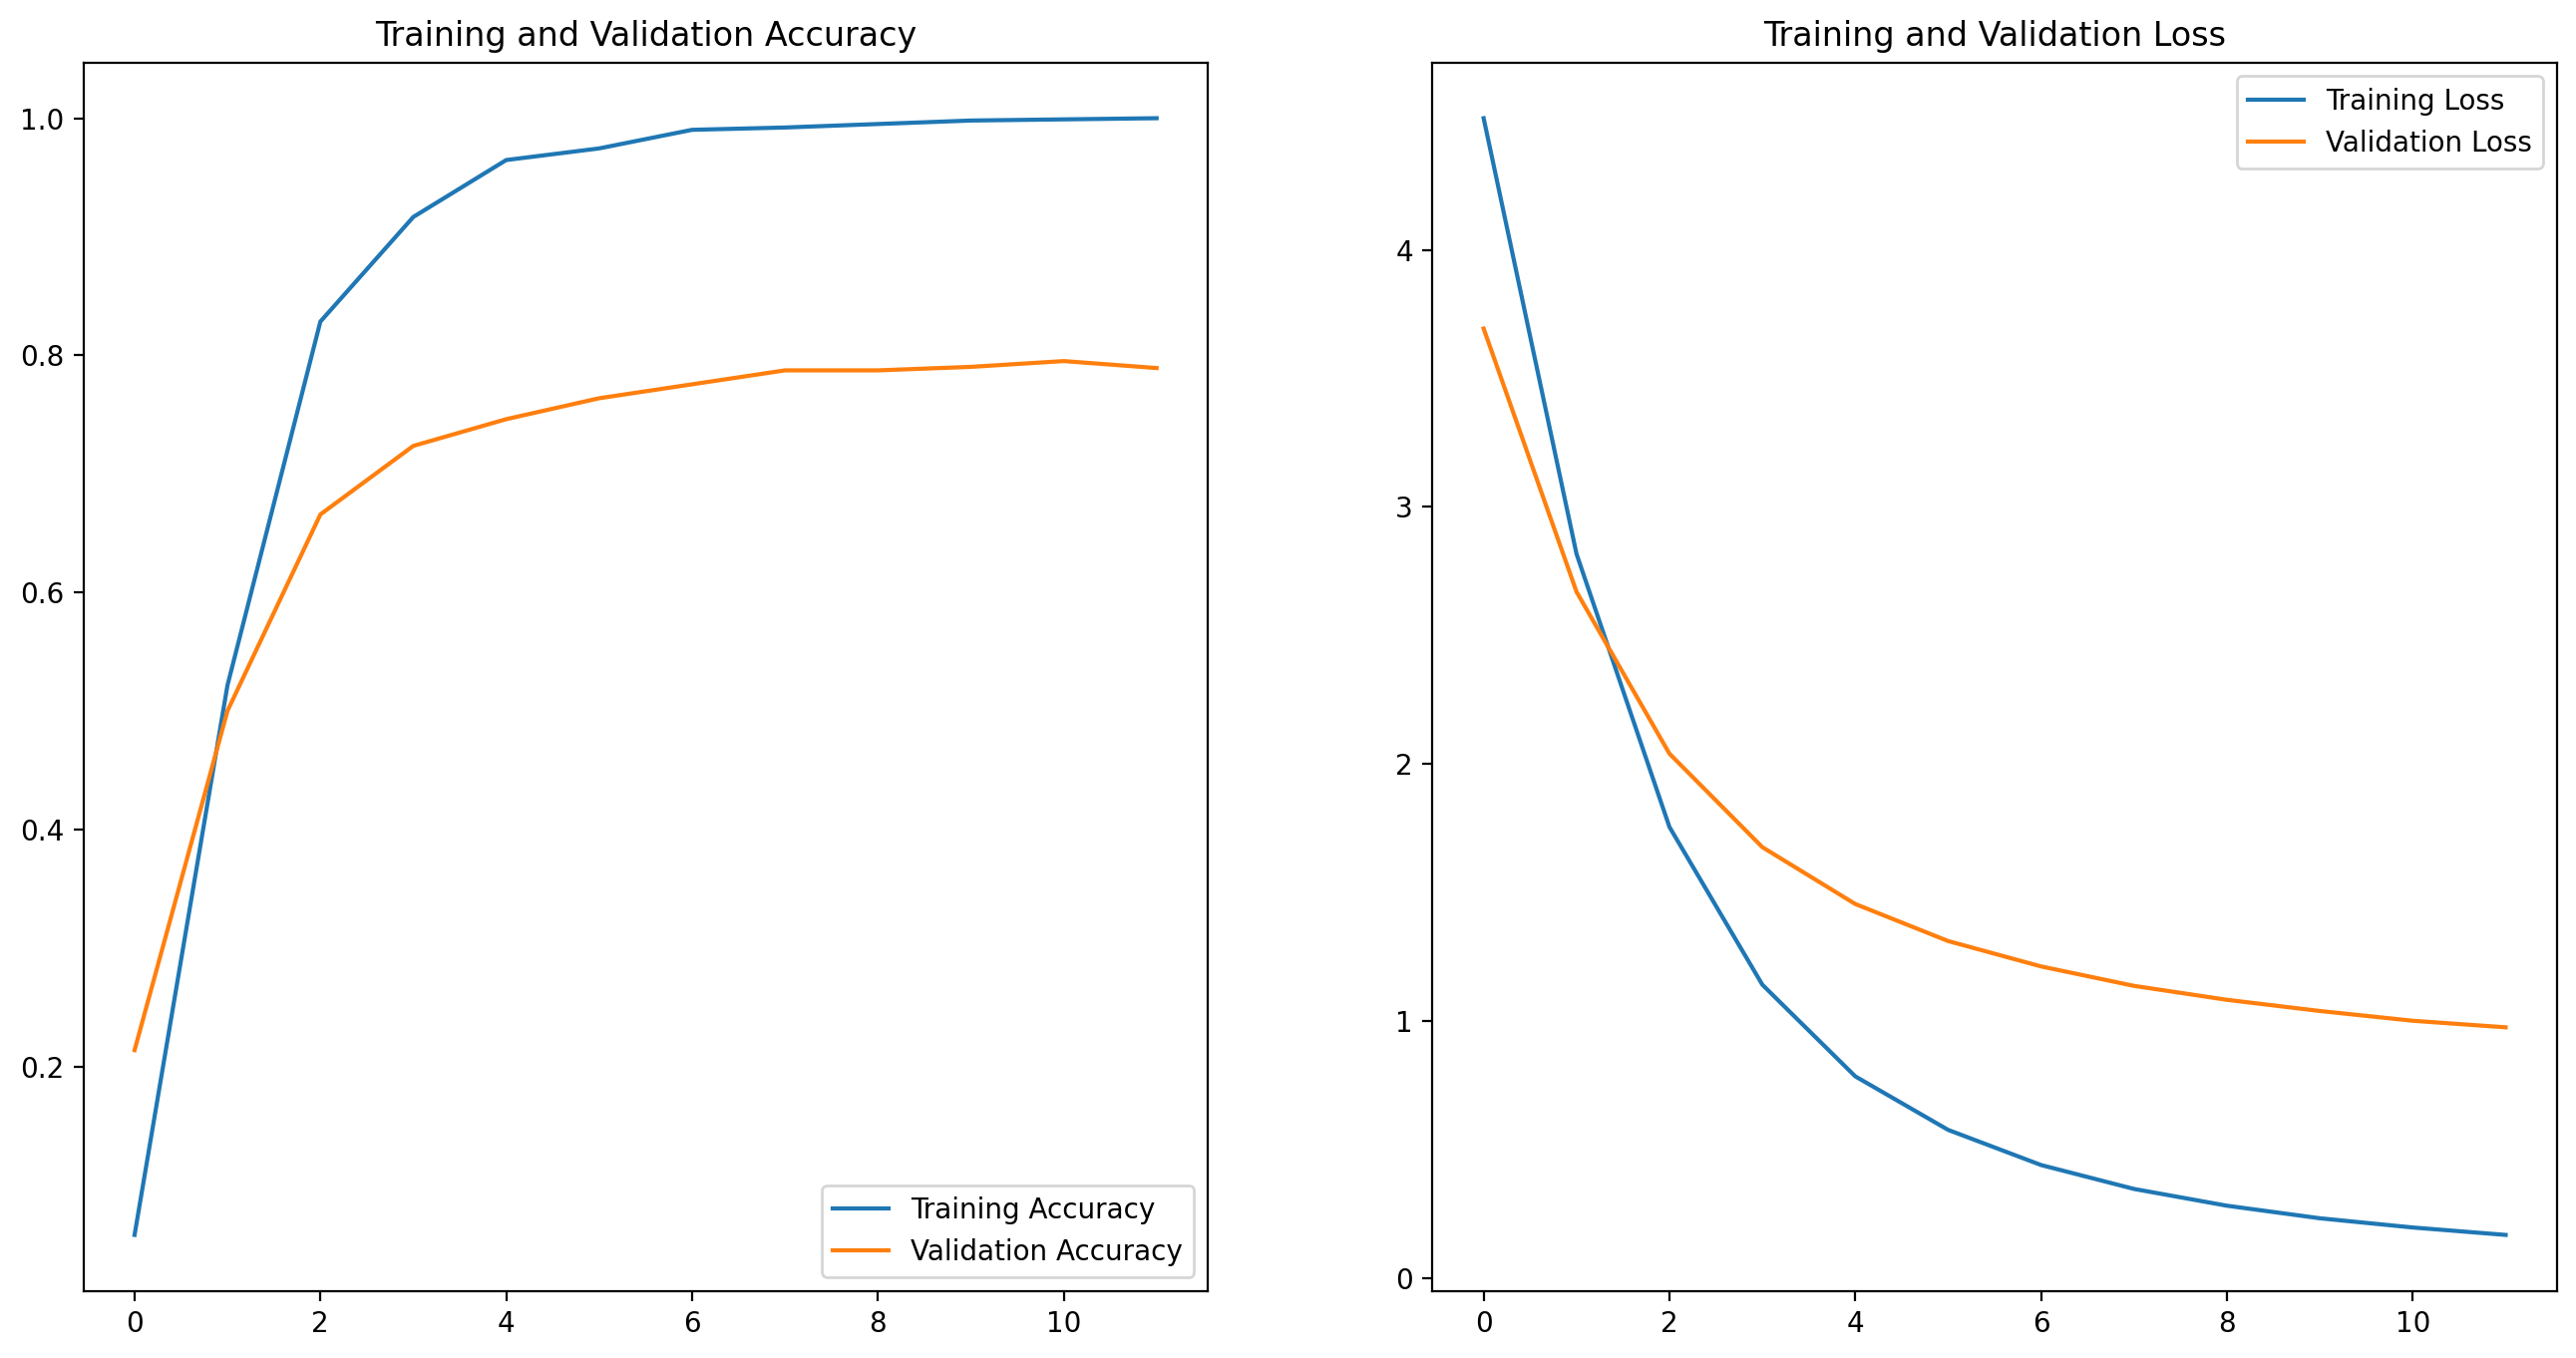

In [15]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.
training_loss, training_accuracy, validation_loss, validation_accuracy = history.history.values()


plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label="Training Accuracy")
plt.plot(validation_accuracy, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(training_loss, label="Training Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [16]:
# TODO: Print the loss and accuracy values achieved on the entire test set.
testing_loss, testing_accuracy = model.evaluate(TESTING_BATCHES)
print(f"Test set metrics: loss of {testing_loss:.2f}, and accuracy of {testing_accuracy:.1%}")

97/97 [==============================] - 35s 361ms/step - loss: 1.0792 - accuracy: 0.7681
Test set metrics: loss of 1.08, and accuracy of 76.8%


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [17]:
# TODO: Save your trained model as a Keras model.
save_model(model)

## Load the Keras Model

Load the Keras model you saved above.

In [20]:
# TODO: Load the Keras model
BEST_MODEL_PATH: str = "./1661623189.h5"  # "./1661623017.h5" for the auto-saved best case
saved_model: tf.keras.Model = tf.keras.models.load_model(BEST_MODEL_PATH, custom_objects={"KerasLayer":hub.KerasLayer})

# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [31]:
# TODO: Create the process_image function
def process_image(image_ndarray: np.ndarray):
    image_tensor = tf.convert_to_tensor(image_ndarray, dtype=tf.float32)
    rescaled_image = tf.image.resize(image_tensor, (IMAGE_SHAPE, IMAGE_SHAPE))
    return rescaled_image.numpy() / 255

To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

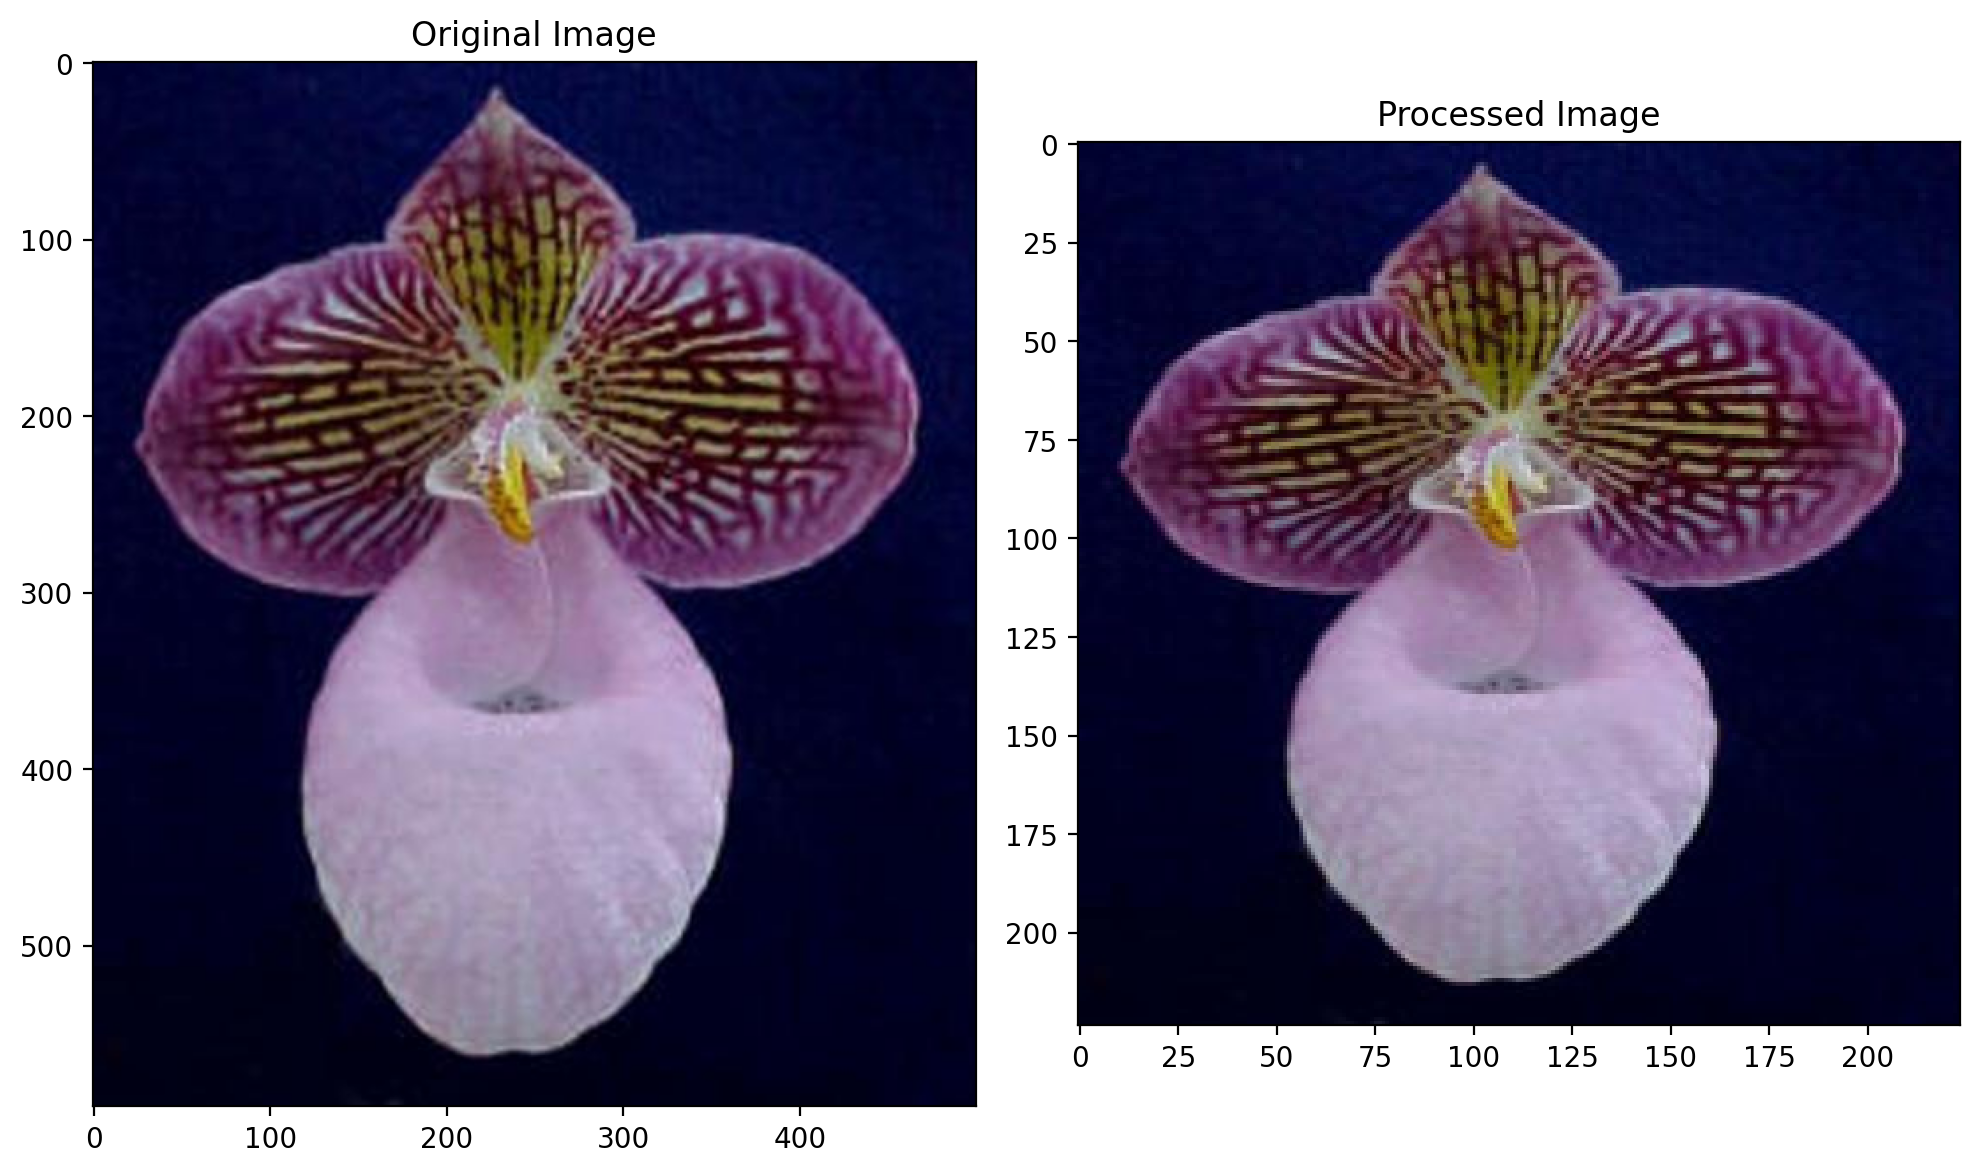

In [32]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [95]:
# TODO: Create the predict function
def predict(image_path: str, model: tf.keras.Model, top_k: int):
    # Read and process image
    image_ndarray = np.asarray(Image.open(image_path))
    processed_image = process_image(image_ndarray)[np.newaxis]
    
    # Cast to dataframe for manipulation
    prediction = pd.DataFrame(
        model(processed_image, training=False)  # perform single-input prediction using `__call__`
            .numpy()
            .flatten(),
        index=range(1, NUMBER_OF_CLASSES + 1),  # associate with labels, in a way that's resistant to sorting
        columns=["probabilities"],
    )
    top_k_results = prediction.sort_values(by=["probabilities"], ascending=False).head(top_k)  # sort
    
    # Extract the two columns
    return top_k_results["probabilities"].values.tolist(), top_k_results.index.tolist()

# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

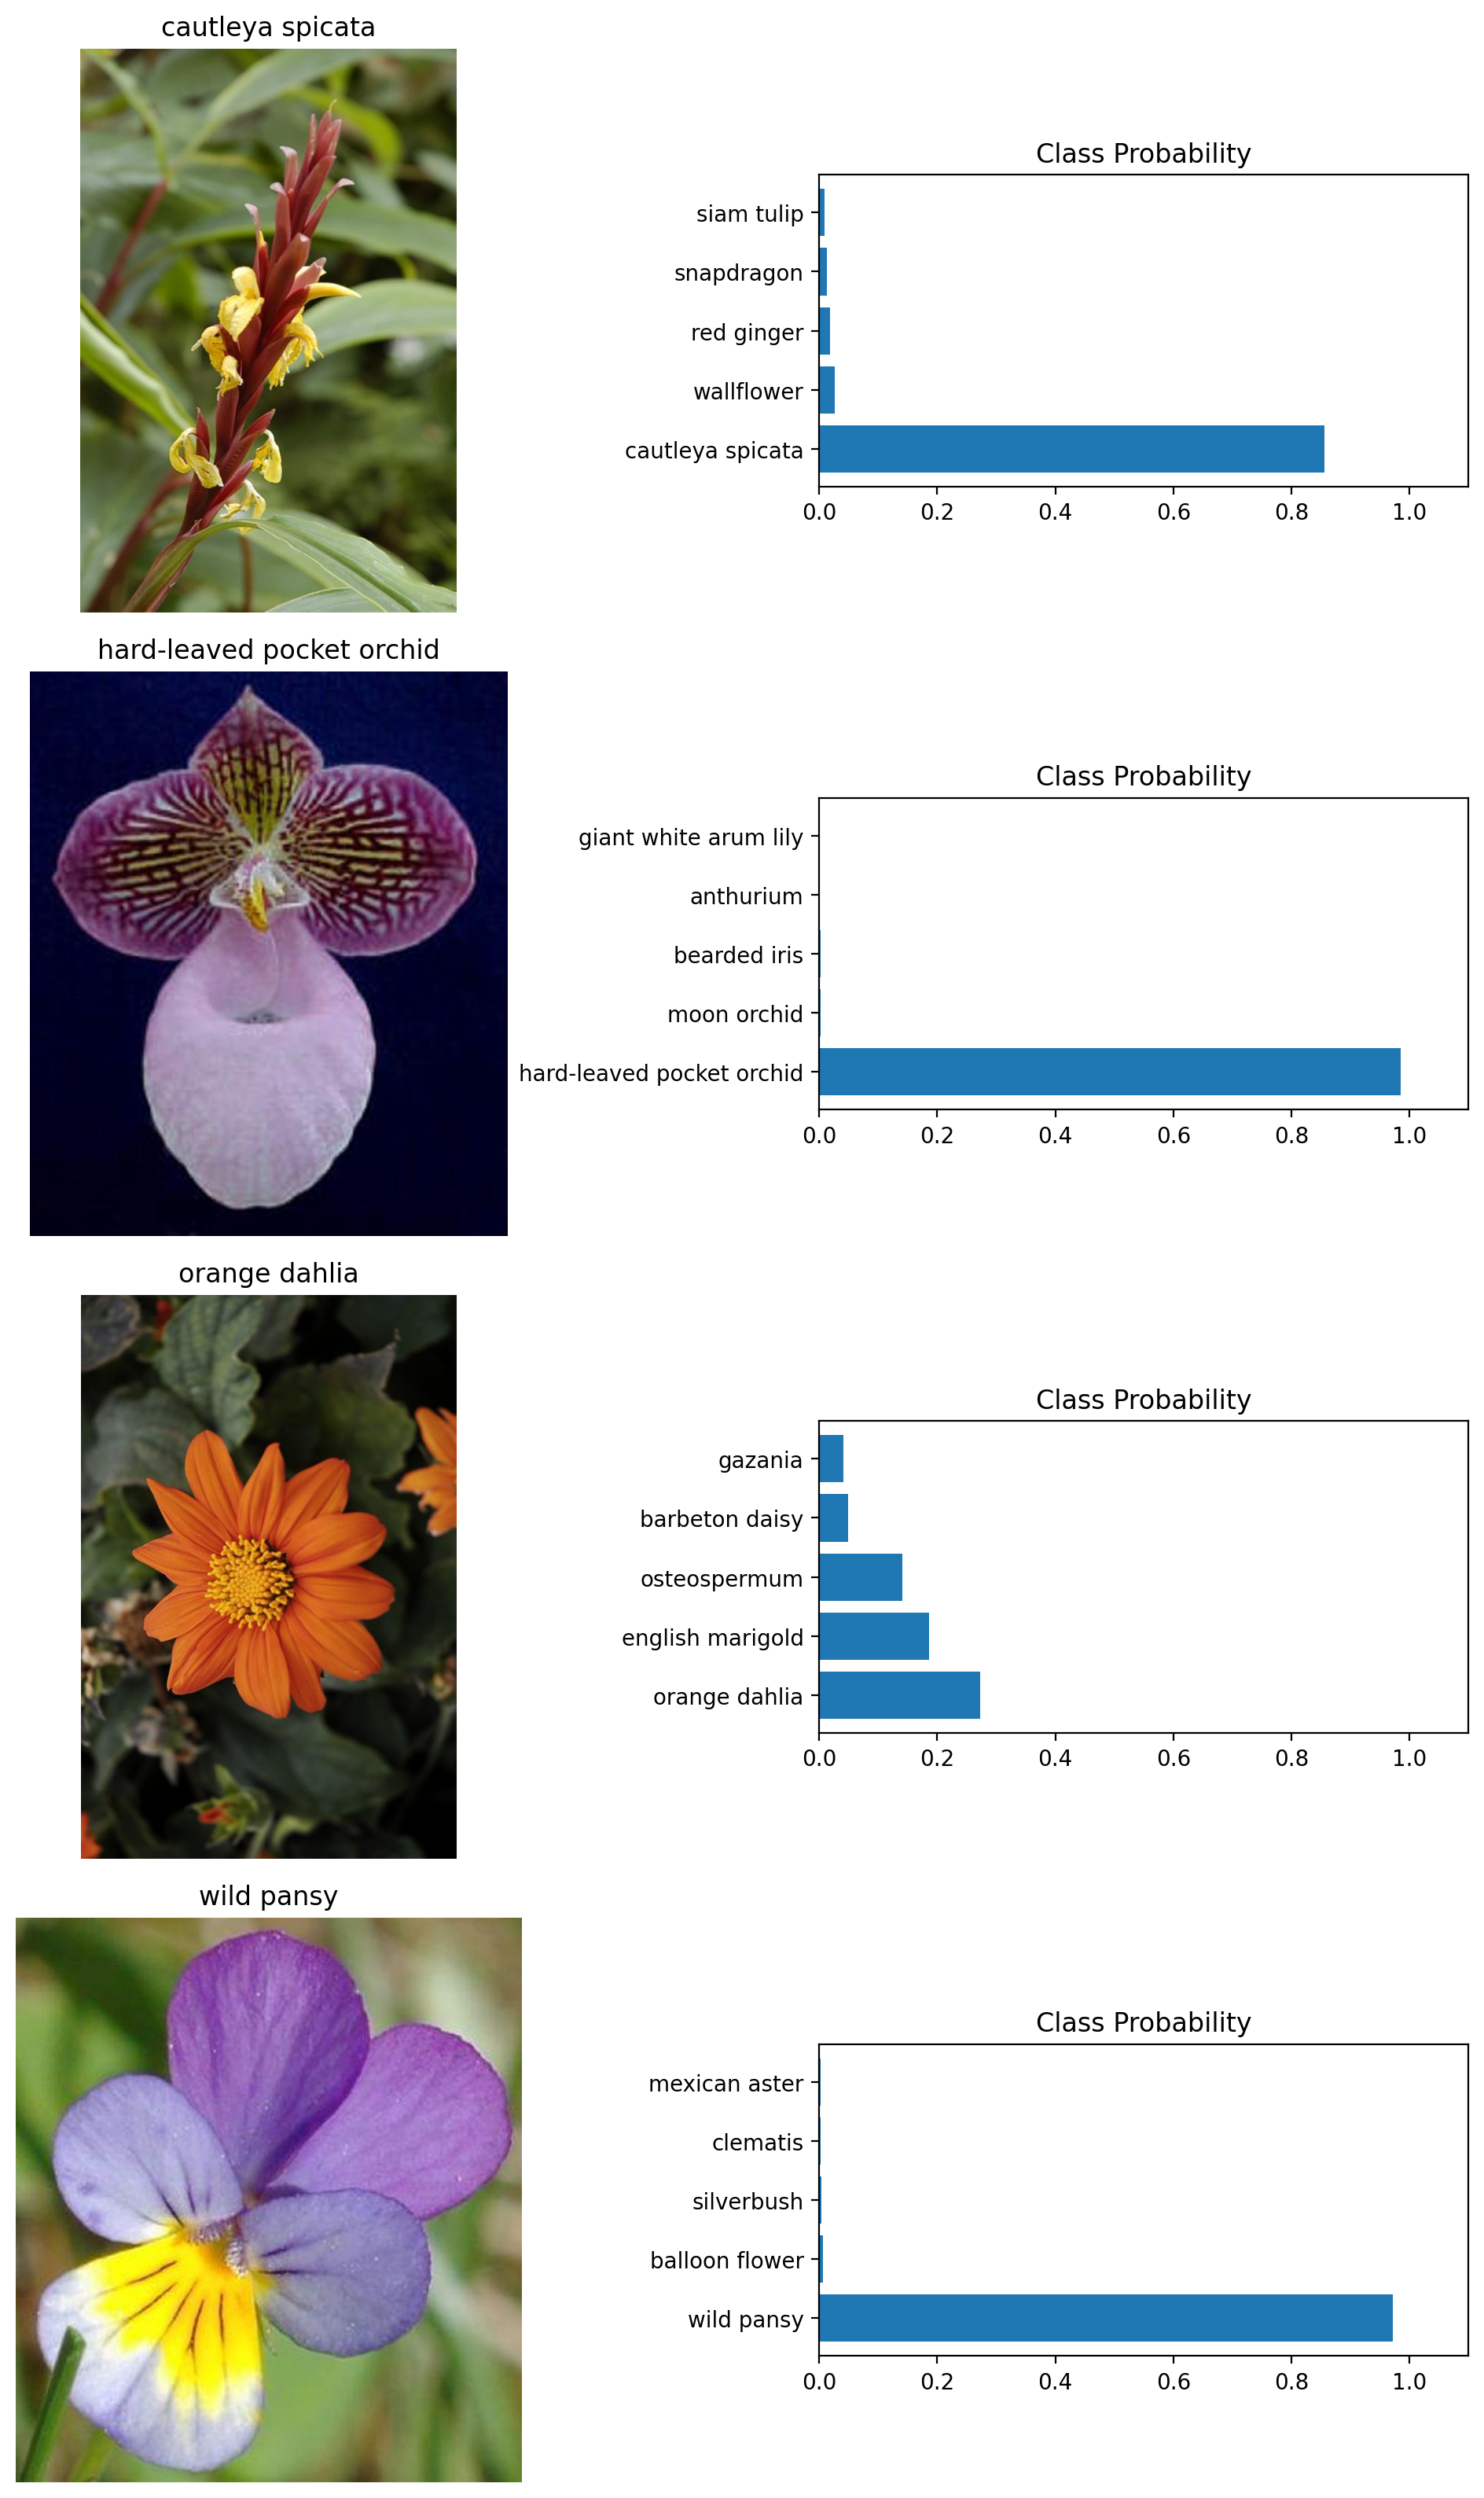

In [124]:
# TODO: Plot the input image along with the top 5 classes
# Helper methods to make it more DRY
def get_test_image_paths() -> list[Path]:
    buffer: list[Path] = []
    for path in Path.cwd().joinpath("test_images").iterdir():
        if path.is_file():
            buffer.append(path)
    return buffer

def get_test_images(paths: list[Path]) -> list[Image]:
    return [Image.open(path) for path in paths]

def get_name_from_path(path: Path) -> str:
    return str(path).split("\\")[-1][:-4].replace("_", " ")  # raw strings don't work for this because Jupyter has issues with smart quotes

# Load images:
paths: list[Path] = get_test_image_paths()
images: list[Image] = get_test_images(paths)

# Predict and set the graph for each image (one row per image):
fig, axs = plt.subplots(len(images), 2)
for index, (path, image) in enumerate(zip(paths, images)):
    # Perform prediction
    probs, classes = predict(path, saved_model, 5)
    labels = [class_names.get(str(element)) for element in classes]
    
    # plot image on the left
    axs[index, 0].imshow(image)
    axs[index, 0].axis("off")
    axs[index, 0].set_title(get_name_from_path(path))
    
    # plot probabilities chart on the right
    axs[index, 1].barh(labels, probs)
    axs[index, 1].set_aspect(0.1)
    axs[index, 1].set_title("Class Probability")
    axs[index, 1].set_xlim(0, 1.1)

fig.set_size_inches(10, 16)
plt.tight_layout()